In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import os
from glob import glob

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
drive_base_path = '/content/drive/My Drive'
test_images_path = os.path.join(drive_base_path, 'test', 'spills')
#list_directory(test_images_path)

In [ ]:
def preprocess_images_hsv(folder_path, target_size=(256, 256)):
    images = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        img = cv2.imread(file_path)  # Load image
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, target_size)  # Resize to target dimensions
            img = img / 150.0  # Normalize to [0, 1]

            hsv_img = cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2HSV) / 255.0
            images.append(hsv_img)

            images.append(img)
    return np.array(images)

# Load all images from the 'test/images' folder
images = preprocess_images_hsv(test_images_path)
print(f"Loaded {len(images)} images.")

Loaded 16 images.


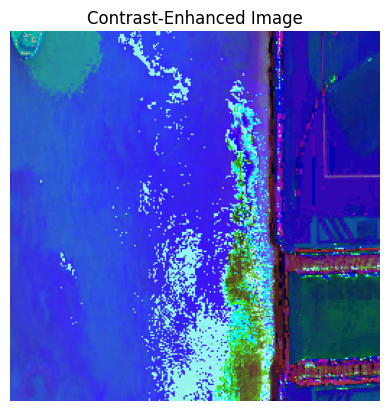

In [ ]:
# Visualize one of the preprocessed images
if len(images) > 0:
    plt.imshow(images[6])  # Display the first image
    plt.title("Contrast-Enhanced Image")
    plt.axis("off")
    plt.show()

In [ ]:
def flatten_image(img):
    return img.reshape((-1, 3))  # Reshape to (num_pixels, 3) for RGB

# Example: Flatten the first image in the dataset
if len(images) > 0:
    flattened_image = flatten_image(images[6])
    print(f"Flattened image shape: {flattened_image.shape}")

Flattened image shape: (65536, 3)


In [ ]:
# Function to apply k-means clustering
def apply_kmeans(image_vector, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(image_vector)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return labels, centroids

# Example: Apply k-means clustering on the first image
if len(images) > 0:
    k = 25  # Number of clusters
    labels, centroids = apply_kmeans(flattened_image, k)
    print(f"K-means completed with {k} clusters.")

K-means completed with 25 clusters.


In [ ]:
# Function to segment image based on k-means clustering
def segment_image(image_vector, labels, centroids, image_shape):
    segmented_vector = centroids[labels].astype('float32')  # Map labels to centroid values
    segmented_image = segmented_vector.reshape(image_shape)  # Reshape back to image dimensions
    return segmented_image

# Example: Segment the first image
if len(images) > 0:
    segmented_image = segment_image(flattened_image, labels, centroids, images[10].shape)
    print("Image segmented.")


Image segmented.


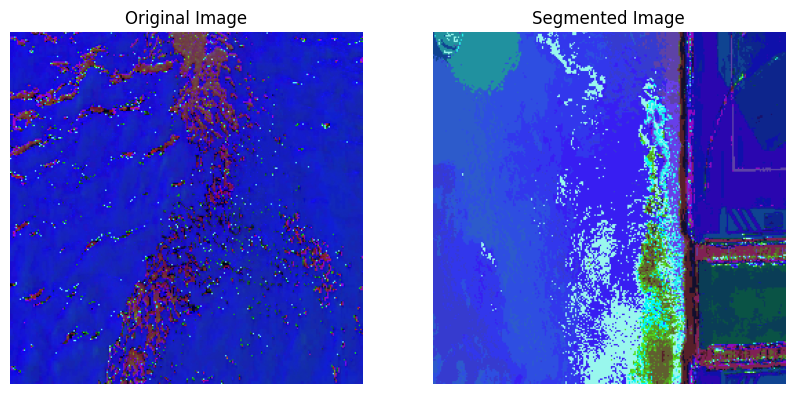

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize original and segmented images
def visualize_segmentation(original, segmented):
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.title("Original Image")
    plt.axis("off")

    # Segmented image
    plt.subplot(1, 2, 2)
    plt.imshow(segmented)
    plt.title("Segmented Image")
    plt.axis("off")

    plt.show()

# Example: Visualize the first image
if len(images) > 0:
    visualize_segmentation(images[10], segmented_image)

In [ ]:
# Function to calculate the percentage of oil spill pixels
def calculate_oil_spill_percentage(labels, centroids, image_shape, oil_color_threshold=(0.2, 0.2, 0.2)):
    #print("Centroids:", centroids)
    oil_clusters = [i for i, centroid in enumerate(centroids)
                    if centroid[0] > oil_color_threshold[0] and
                       centroid[1] > oil_color_threshold[1] and
                       centroid[2] > oil_color_threshold[2]]
    oil_pixels = np.sum(np.isin(labels, oil_clusters))  # Count pixels in oil spill clusters
    total_pixels = image_shape[0] * image_shape[1]  # Total number of pixels in the image
    return (oil_pixels / total_pixels) * 100

# Example: Calculate oil spill percentage for the first image
if len(images) > 0:
    spill_percentage = calculate_oil_spill_percentage(labels, centroids, images[10].shape)
    print(f"Oil Spill Percentage: {spill_percentage:.2f}%")


Oil Spill Percentage: 16.86%


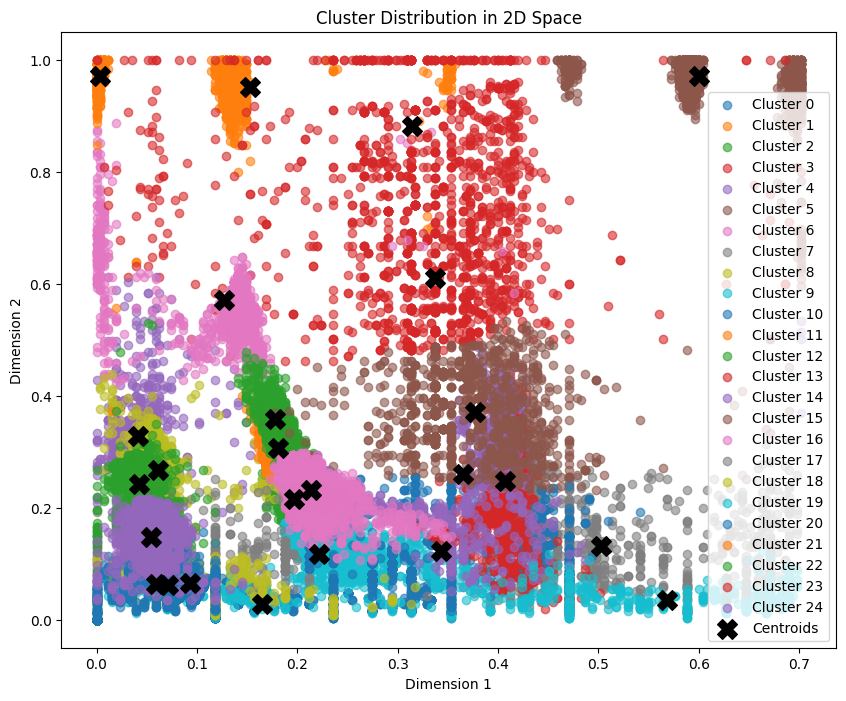

In [ ]:
def visualize_clusters_2d(data, labels, centroids, title="Cluster Distribution in 2D"):
    plt.figure(figsize=(10, 8))

    # Scatter plot of data points, colored by cluster labels
    for cluster_id in range(len(centroids)):
        cluster_points = data[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.6)

    # Plot centroids
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label='Centroids')

    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.show()

# Example: Visualize clusters in 2D space
# This assumes your data is in 2D (e.g., after PCA)
visualize_clusters_2d(flattened_image, labels, centroids, title="Cluster Distribution in 2D Space")


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


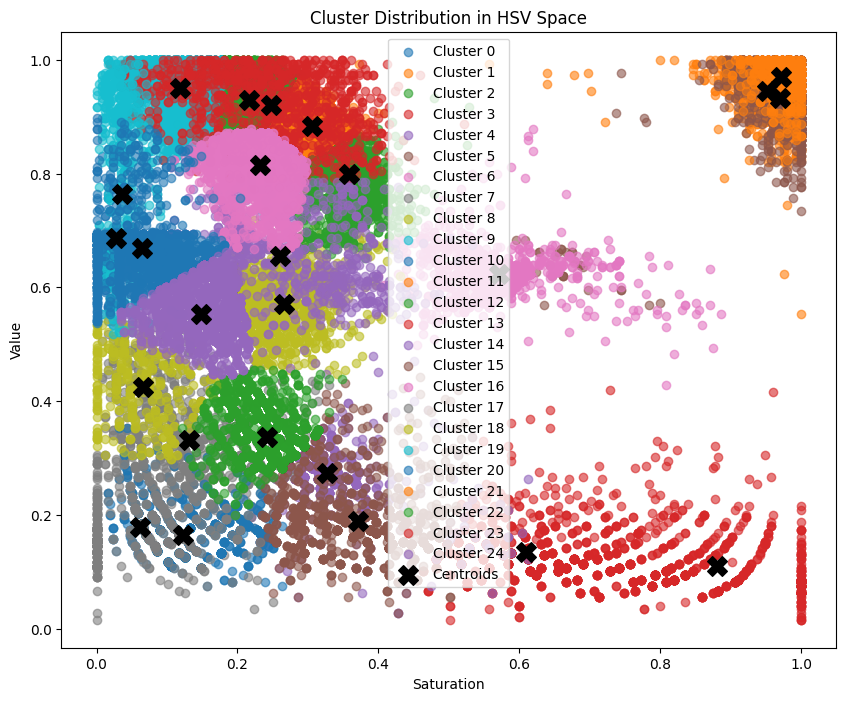

In [ ]:
def visualize_clusters_2d(data, labels, centroids, title="Cluster Distribution in 2D"):

    plt.figure(figsize=(10, 8))
    for cluster_id in range(len(centroids)):
        cluster_points = data[labels == cluster_id]
        plt.scatter(cluster_points[:, 1], cluster_points[:, 2], label=f"Cluster {cluster_id}", alpha=0.6)  # Plot S vs. V

    # Plot centroids
    plt.scatter(centroids[:, 1], centroids[:, 2], c='black', marker='X', s=200, label='Centroids')

    plt.title(title)
    plt.xlabel("Saturation")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# Visualize clusters in 2D (Saturation vs. Value)
visualize_clusters_2d(flattened_image, labels, centroids, title="Cluster Distribution in HSV Space")


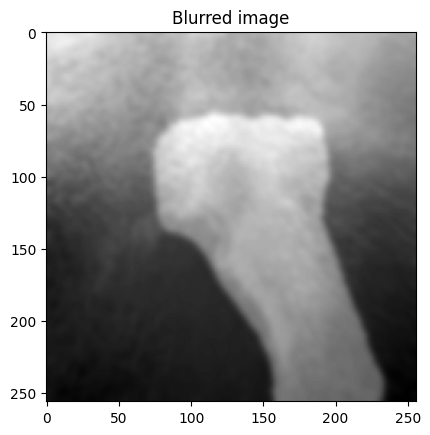

In [ ]:
drive_base_path = '/content/drive/My Drive'
path1256 = os.path.join(drive_base_path, 'test', 'spills','Oil (1256).jpg')
img1256=cv2.imread(path1256)
img1256=cv2.resize(img1256,(256,256))
img1256=cv2.cvtColor(img1256,cv2.COLOR_BGR2RGB)
gray1256 = cv2.cvtColor(img1256, cv2.COLOR_RGB2GRAY)

blurredgray1256=cv2.GaussianBlur(gray1256, (13, 13), 0)
plt.title('Blurred image')
plt.imshow(blurredgray1256,cmap='gray')

_,otsu1256=cv2.threshold(blurredgray1256,0,255,cv2.THRESH_OTSU)

_,tri1256=cv2.threshold(blurredgray1256,0,255,cv2.THRESH_TRIANGLE)

0.4222259521484375


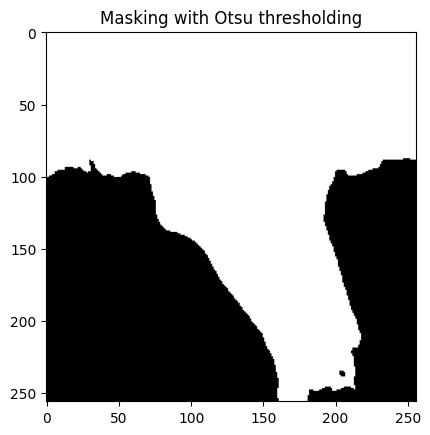

In [ ]:
plt.imshow(otsu1256,cmap='gray')
plt.title('Masking with Otsu thresholding')
black=np.sum(otsu1256==0)
print(black/(256*256))


3203834
0.3043906643695605


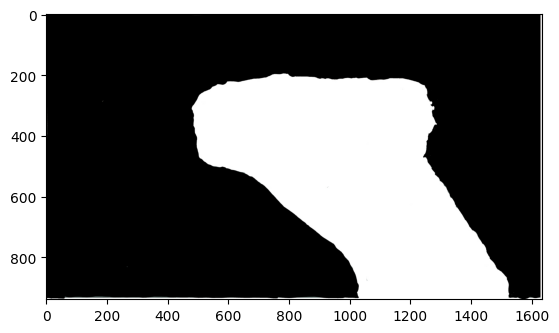

In [ ]:
drive_base_path = '/content/drive/My Drive'
pathbw=os.path.join(drive_base_path,'test','IMG_0570.jpg')
bwimg=cv2.imread(pathbw)
black=np.sum(bwimg==0)
h,w=bwimg.shape[:2]
print(black)
total=h*w*3
print(1-(black/total))
plt.imshow(bwimg,cmap='gray')

In [ ]:
#imports black and white photos
drive_base_path = '/content/drive/My Drive'
bw_path = os.path.join(drive_base_path, 'test', 'blackwhite')
bws=[]
for file_name in os.listdir(bw_path):
    file_path = os.path.join(bw_path, file_name)
    img = cv2.imread(file_path)  # Load image
    if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, (256,256))  # Resize to target dimensions
        img = img / 150.0  # Normalize to [0, 1]

        bws.append(img)

In [ ]:
for i in range(0,8):
  black=np.sum(bws[i]==0)
  h,w=bws[i].shape[:2]
  total=h*w*3
  print(1-(black/total),os.listdir(bw_path)[i])


0.30588785807291663 bw1256.jpg
0.33632405598958337 bw1252.jpg
0.188201904296875 bw811.jpg
0.3503265380859375 bw1178.jpg
0.1792755126953125 bw1097.jpg
0.182891845703125 bw1186.jpg
0.19388326009114587 bw1220.jpg
0.18056742350260413 bw74.jpg


Text(0.5, 1.0, 'Manual Mask')

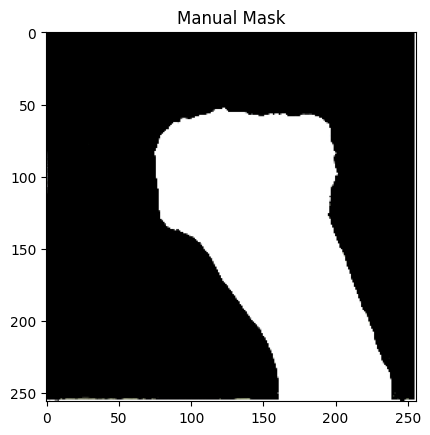

In [ ]:
plt.imshow(bws[0])
plt.title('Manual Mask')